# Bibliotecas Utilizadas

In [26]:
# Bibliotecas utilizadas e configurações
from time import time

# Plotagens
import matplotlib.pyplot as plt

# Manipulação das imagens e datasets
import numpy as np
import pandas as pd
from PIL import Image

# Particionamento de dados e métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Modelo de CNN, utilizando Keras
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

# Redução de dimensionalidade
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

# Modelo SVC
from sklearn.svm import SVC

# Manipulação de pastas
import os
import shutil

# Ordenação de listas
from collections import OrderedDict

%matplotlib inline

t0 = time()

# Coleta e Preparação dos Dados

In [2]:
# Inicia o dataframe de imagens para conter o nome da personalidade e o caminho para as suas imagens
# Uma imagem por linha
lfw_allnames = pd.read_csv("lfw_allnames.csv")
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)
image_paths

,name,image_path
0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg
...,...,...
5744,Zorica_Radovic,Zorica_Radovic/Zorica_Radovic_0001.jpg
5745,Zulfiqar_Ahmed,Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg
5746,Zumrati_Juma,Zumrati_Juma/Zumrati_Juma_0001.jpg
5747,Zurab_Tsereteli,Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg


In [3]:
# Exibe a distribuição de imagens por celebridade 
def show_dist(names, limit):
    print(names.value_counts()[:limit])
    names.value_counts()[:limit].plot.bar()

In [4]:
# Exibe uma imagem
def show_img(img_path, title):
    im = Image.open("lfw-deepfunneled/lfw-deepfunneled/" + str(img_path))
    plt.title(title)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [5]:
# Copia as imagens informadas para uma pasta, usado para distribuir as imagens para as pastas de treino e teste
def copy_to_directory(data, dir_name):
    count = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(dir_name):
            shutil.os.mkdir(dir_name)
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join(dir_name, data_type)):
            shutil.os.mkdir(os.path.join(dir_name, data_type))
        path_from = os.path.join('lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join(dir_name, data_type)
        #print(path_to)
        
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        count += 1
        
    print('{} imagens copiadas para a pasta {}.'.format(count, dir_name))

In [6]:
# Função para predizer as classes (celebridades) a partir de um diretório de testes e do classificador já treinado
def predictions(dir_name,classifier):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64


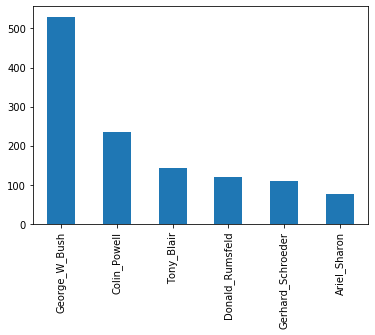

In [7]:
# Distribuição original de imagens por celebridade
show_dist(image_paths['name'], 6)

Tony_Blair           77
Gerhard_Schroeder    77
Colin_Powell         77
George_W_Bush        77
Ariel_Sharon         77
Donald_Rumsfeld      77
Name: name, dtype: int64


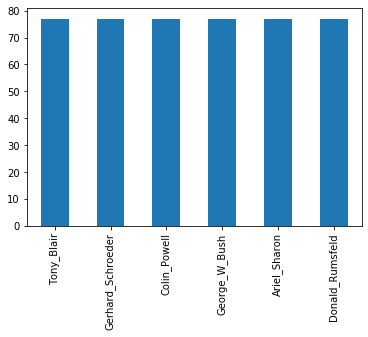

In [8]:
# Como a distribuição original é desbalanceada, é feita uma amostra de um número fixo de imagens por celebridade,
# aproveitando-se as celebridades que tem o maior número de imagens, obtendo-se um dataset balanceado
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(77),
                        image_paths[image_paths.name=="Colin_Powell"].sample(77),
                        image_paths[image_paths.name=="Tony_Blair"].sample(77),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(77),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(77),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(77)])

show_dist(multi_data['name'], 6)

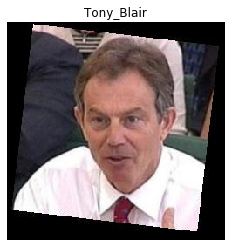

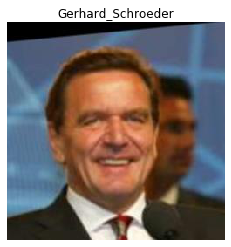

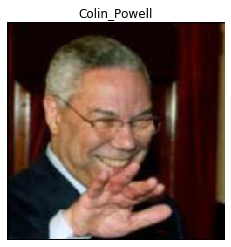

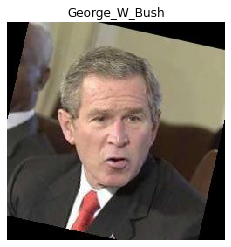

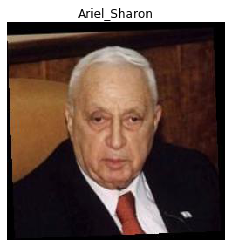

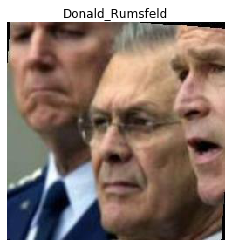

In [9]:
# Exibe as imagens das celebridades que serão submetidas ao treino
names = multi_data.name.value_counts()[:6]

for name in names.index:
    show_img(multi_data.image_path[multi_data.name == name].iloc[0], name)

# Modelo de Reconhecimento de Rosto Utilizando SVC

In [19]:
%%time
# Preprocessamento das imagens: cria um dataset das features (X) no formato para treinamento com SVC
# linhas = número de amostras
# colunas = 250 x 250 = 62.500 parametros (features)
# As imagens são convertidas para tons de cinza e ficam com apenas 1 dimensão (flatten)
X = np.zeros((len(multi_data), 62500)) 

for i, path in enumerate(multi_data.image_path):
    img = Image.open("lfw-deepfunneled/lfw-deepfunneled/" + path).convert('L')
    img_array = np.array(img.getdata()).reshape(img.size[0], img.size[1], 1)
    flattened = img_array.flatten()
    X[i] = flattened

n_features = X.shape[1]
print("n_features: %d" % n_features)
print("X:")
print(X.shape)
print("\n")

n_features: 62500
X:
(462, 62500)


CPU times: user 4.43 s, sys: 104 ms, total: 4.54 s
Wall time: 4.55 s


In [20]:
# Gera o vetor de rótulos (y) e os nomes das celebridades correspondentes
target_names = ["George_W_Bush", "Colin_Powell", "Tony_Blair", "Donald_Rumsfeld", "Gerhard_Schroeder", "Ariel_Sharon"]

y = np.zeros(len(multi_data))

for i, name in enumerate(multi_data.name):
    y[i] = target_names.index(name)
    
n_classes = len(np.unique(y))
print("Número de classes: %d" % n_classes)
print("y:")
print(y.shape)

Número de classes: 6
y:
(462,)


In [21]:
# Divisão em dados de treinamento e de teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

print("Tamanho treinamento: " )
print(X_train.shape)
print("Tamanho teste: ")
print(X_test.shape)

Tamanho treinamento: 
(369, 62500)
Tamanho teste: 
(93, 62500)


In [24]:
# Aplica a técnica PCA para redução de dimensionalidade da imagem
n_components = 300

print("Extraindo os %d componentes mais importantes de %d parâmetros originais"
      % (n_components, X_train.shape[1]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("Concluído em %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, 250, 250))

print("Aplicando PCA nos dados de treinamento e de teste")
t0 = time()
X_train_pca = pca.transform(X_train)
#X_test_pca = pca.transform(X_test)
print("Concluído em %0.3fs" % (time() - t0))

Extraindo os 300 componentes mais importantes de 62500 parâmetros originais
Concluído em 5.372s
Aplicando PCA nos dados de treinamento e de teste
Concluído em 0.302s


In [27]:
# Treino do modelo de classificação, utilizando SVM

print("Treinando")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("Concluído em %0.3fs" % (time() - t0))
print("Parâmetros encontrados pelo Grid Search:")
print(clf.best_estimator_)

Treinando


/home/andre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Concluído em 5.614s
Parâmetros encontrados pelo Grid Search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/home/andre/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
# Quantitative evaluation of the model quality on the test set
print("Métricas para a predição do nome das personalidades para o conjunto de teste")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

print("Matriz de Confusão")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.018s
                   precision    recall  f1-score   support

    George_W_Bush       0.67      0.80      0.73        20
     Colin_Powell       0.90      0.60      0.72        15
       Tony_Blair       0.75      0.75      0.75        16
  Donald_Rumsfeld       0.82      0.75      0.78        12
Gerhard_Schroeder       0.62      0.73      0.67        11
     Ariel_Sharon       0.95      0.95      0.95        19

         accuracy                           0.77        93
        macro avg       0.78      0.76      0.77        93
     weighted avg       0.79      0.77      0.77        93

[[16  0  1  1  2  0]
 [ 3  9  1  1  0  1]
 [ 1  1 12  0  2  0]
 [ 0  0  2  9  1  0]
 [ 3  0  0  0  8  0]
 [ 1  0  0  0  0 18]]


# Modelo de Reconhecimento de Rosto Utilizando CNN

In [33]:
# Divisão dos dados em treino e teste
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)

# Divisão dos dados de treino em treino e validação
#multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

print('Dados de treino: {}'.format(multi_train.shape[0]))
#print('Dados de validação: {}'.format(multi_val.shape[0]))
print('Dados de teste: {}'.format(multi_test.shape[0]))

Dados de treino: 369
Dados de teste: 93


In [34]:
# Deleta as pastas de treino e teste para nova interação
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
#if "val_multi" in os.listdir("./"):
#    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")

In [35]:
# Copia as imagens para as respectivas pastas de treino e teste
copy_to_directory(multi_train,"train_multi/")
#copy_to_directory(multi_val,"val_multi/")
copy_to_directory(multi_test,"test_multi/")

369 imagens copiadas para a pasta train_multi/.
93 imagens copiadas para a pasta test_multi/.


In [36]:
# Define o conjunto de dados de treino e teste, prontos para treinamento
# Utiliza data augmentation para os dados de treino
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

multi_training_set = train_datagen.flow_from_directory('train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

#multi_val_set = test_datagen.flow_from_directory('val_multi/',
#                                            target_size = (250, 250),
#                                            batch_size = 32,
#                                            class_mode = 'categorical')

multi_test_set = test_datagen.flow_from_directory('test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')



Found 369 images belonging to 6 classes.
Found 93 images belonging to 6 classes.


In [38]:
# Definição do modelo
multi_classifier = Sequential()

multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))

multi_classifier.add(Flatten())

multi_classifier.add(Dense(units = 128, activation = 'relu'))
# as we are training on several classes, we need several classification units (one for each class). We also use a 
# softmax activation function
multi_classifier.add(Dense(units = 6, activation = 'softmax'))

# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [39]:
# Treinamento do modelo
t1 = time()
multi_history = multi_classifier.fit_generator(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               #steps_per_epoch = 11,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 50,
                                               #validation_data = multi_val_set,
                                               #validation_steps = 11
                                              )
tempo_minutos = int((time() - t1)/60)
tempo_segundos = (time() - t1)%60
print("Concluído em: {} minutos {} segundos".format(tempo_minutos, round(tempo_segundos, 2)))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
12/12 [==============================] - 11s 942ms/step - loss: 17.0584 - accuracy: 0.2331
Epoch 2/50
12/12 [==============================] - 11s 920ms/step - loss: 2.5838 - accuracy: 0.2737
Epoch 3/50
12/12 [==============================] - 11s 958ms/step - loss: 1.6599 - accuracy: 0.3225
Epoch 4/50
12/12 [==============================] - 9s 769ms/step - loss: 1.6415 - accuracy: 0.3713
Epoch 5/50
12/12 [==============================] - 10s 797ms/step - loss: 1.5604 - accuracy: 0.4146
Epoch 6/50
12/12 [==============================] - 9s 740ms/step - loss: 1.4697 - accuracy: 0.4444
Epoch 7/50
12/12 [==============================] - 9s 763ms/step - loss: 1.3576 - accuracy: 0.5068
Epoch 8/50
12/12 [==============================] - 10s 796ms/step - loss: 1.2810 - accuracy: 0.4959
Epoch 9/50
12/12 [==============================] - 9s 753ms/step - loss: 1.1866 - accuracy: 0.5474
Epoch 10/50
12/12 

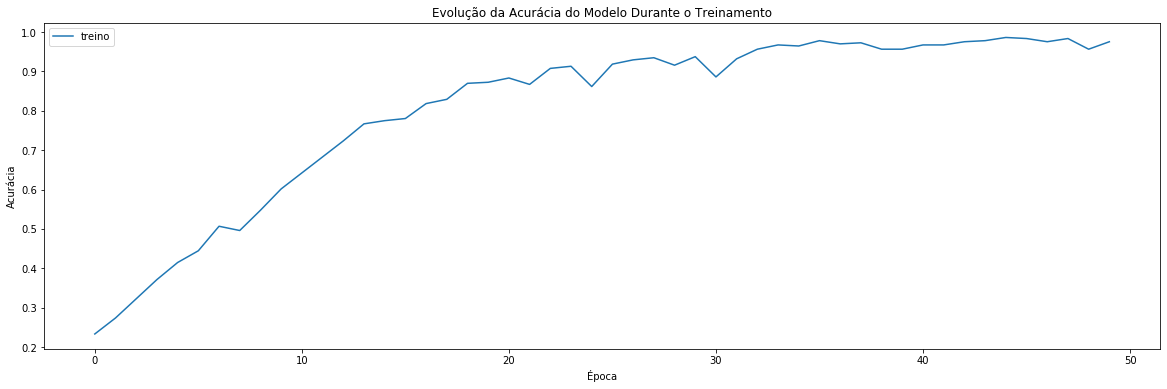

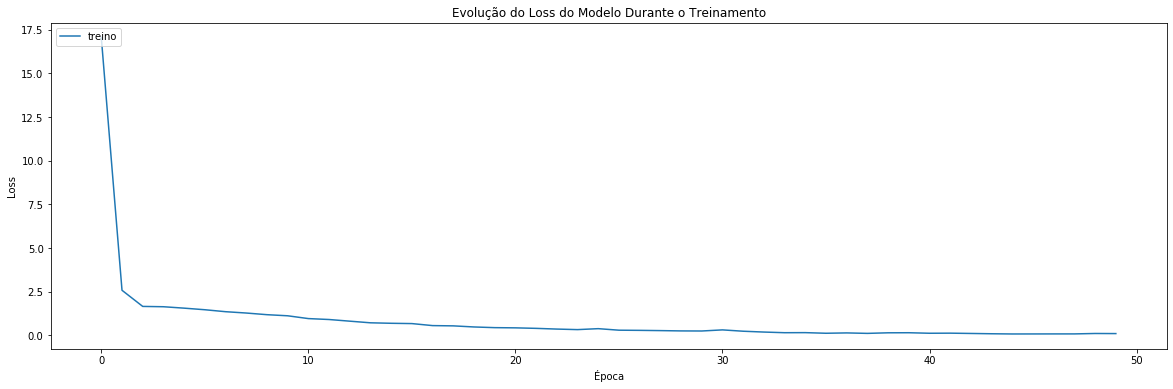

In [41]:
# Análise do treinamento
plt.figure(figsize=(20, 6))
plt.plot(multi_history.history['accuracy'])
#plt.plot(multi_history.history['val_accuracy'])
plt.title('Evolução da Acurácia do Modelo Durante o Treinamento')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(multi_history.history['loss'])
#plt.plot(multi_history.history['val_loss'])
plt.title('Evolução do Loss do Modelo Durante o Treinamento')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

In [42]:
# Obtem o nome das classes na ordem que elas foram passadas para o treinamento
multi_test_names = []

for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])

for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

multi_test_name_order

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Tony_Blair']

In [43]:
# Realiza a predição do classificador para cada classe, a partir do conjunto de teste
multi_predictions_0 = predictions("test_multi/" + multi_test_name_order[0] + "/",multi_classifier)
multi_predictions_1 = predictions("test_multi/" + multi_test_name_order[1] + "/",multi_classifier)
multi_predictions_2 = predictions("test_multi/" + multi_test_name_order[2] + "/",multi_classifier)
multi_predictions_3 = predictions("test_multi/" + multi_test_name_order[3] + "/",multi_classifier)
multi_predictions_4 = predictions("test_multi/" + multi_test_name_order[4] + "/",multi_classifier)
multi_predictions_5 = predictions("test_multi/" + multi_test_name_order[5] + "/",multi_classifier)

In [44]:
# Monta uma tabela contendo um registro correspondente para cada linha do conjunto de teste
# Cada linha contem a classe predito e a verdadeira
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predito','Real'])
multi_predictions_frame

,Predito,Real
0,0,0
1,0,0
2,3,0
3,5,0
4,0,0
...,...,...
88,5,5
89,5,5
90,5,5
91,3,5


In [45]:
# Calcula as métricas do classificador
def calc_metrics(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    total_preds = predictions_frame.shape[0]
    for i in range(len(set(predictions_frame.Predito))):
        tp = predictions_frame[np.logical_and(predictions_frame['Real'] == i, predictions_frame['Predito'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Real'] != i, predictions_frame['Predito'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Real'] != i, predictions_frame['Predito'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Real'] == i, predictions_frame['Predito'] != i)].shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy, precision, recall)

In [46]:
multi_accuracy = calc_metrics(multi_predictions_frame)

metrics = pd.DataFrame(list(zip(multi_test_name_order, multi_accuracy[0], multi_accuracy[1], multi_accuracy[2])),
                      columns = ['Nome','Acuracia', 'Precisao', 'Recall'])

print('Acurácia geral: {}'.format(round(metrics.Acuracia.mean(), 2)))

metrics

Acurácia geral: 0.9


,Nome,Acuracia,Precisao,Recall
0,Ariel_Sharon,0.956989,0.846154,0.846154
1,Colin_Powell,0.903226,1.000000,0.357143
2,Donald_Rumsfeld,0.924731,0.842105,0.800000
3,George_W_Bush,0.881720,0.600000,0.642857
4,Gerhard_Schroeder,0.946237,1.000000,0.642857
5,Tony_Blair,0.806452,0.500000,0.888889


In [47]:
# Deleta as pastas de treino e teste para nova interação
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")

In [48]:
tempo_minutos = int((time() - t0)/60)
tempo_segundos = (time() - t0)%60
print("Tempo total decorrido na execução de todo o script: {} minutos {} segundos".format(tempo_minutos, round(tempo_segundos, 2)))

Tempo total decorrido na execução de todo o script: 25 minutos 43.94 segundos
